# **Model Training (Detection)**

### **Extra tools**

In [2]:
import winsound
from plyer import notification

def notify_user(header,message):
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    notification.notify(
        title= header,
        message= message,
        timeout=10
    )

### **Libraries Used**

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

### **Load dataset**

In [4]:
df_pivot = pd.read_csv("pivot_dataset.csv", low_memory=False)

## **Pre-trainig**

**Map quality strings to numeric**

In [5]:
quality_map = {
    "Good": 1.0,
    "Estimated": 0.75,
    "Suspect": 0.5,
    "Contamination": 0.0
}

quality_columns = ['Dissolved Gas', 'EC', 'Optical', 'Oxidized Nitrogen', 
                   'Phosphorus', 'Salinity', 'Temperature', 'pH']

for col in quality_columns:
    if col in df_pivot.columns:
        df_pivot[col] = df_pivot[col].map(quality_map)

**Handle missing values**

In [6]:
numeric_cols = df_pivot.select_dtypes(include=['float64','int64']).columns
df_pivot[numeric_cols] = df_pivot[numeric_cols].fillna(df_pivot[numeric_cols].mean())
df_pivot = df_pivot.fillna(0)

**Encode target variable**

In [7]:
df_pivot['Target'] = df_pivot['Target'].map({'fair':0, 'good':1})

**Convert Sample.Date to datetime and extract features**

In [8]:
df_pivot['Sample.Date'] = pd.to_datetime(df_pivot['Sample.Date'], errors='coerce')
df_pivot['Year'] = df_pivot['Sample.Date'].dt.year
df_pivot['Month'] = df_pivot['Sample.Date'].dt.month

**Drop unnecessary columns**

In [9]:
df_pivot.drop(['GEMS.Station.Number', 'Sample.Date', 'Sample.Time', 'Final_Quality'], 
              axis=1, inplace=True, errors='ignore')

**Final dataset ready for ML**

In [10]:
print(df_pivot.head())
print("Shape:", df_pivot.shape)

   Depth  Dissolved Gas   EC  Optical  Oxidized Nitrogen  Phosphorus  \
0   0.25            1.0  1.0      0.5                1.0    0.810589   
1   0.20            0.5  1.0      0.0                1.0    0.000000   
2   0.20            1.0  1.0      0.0                1.0    0.810589   
3   0.18            1.0  1.0      0.0                1.0    1.000000   
4   0.27            1.0  1.0      0.0                1.0    1.000000   

   Salinity  Temperature        pH  Target  Year  Month  
0  0.783831          1.0  1.000000       0  2018      8  
1  0.783831          1.0  1.000000       0  2018     11  
2  0.783831          1.0  1.000000       0  2019      2  
3  0.783831          1.0  1.000000       0  2019      5  
4  0.783831          1.0  0.954819       0  2019      8  
Shape: (789370, 12)


**Data split**

In [11]:
df = df_pivot.copy()

X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **Random Forest**

Confusion Matrix:
[[71033     4]
 [    0 86837]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71037
           1       1.00      1.00      1.00     86837

    accuracy                           1.00    157874
   macro avg       1.00      1.00      1.00    157874
weighted avg       1.00      1.00      1.00    157874

Balanced Accuracy: 0.999972

Cross-Validation Scores: [0.99997466 1.         1.         1.         0.99998733]
Mean CV Accuracy: 0.999992


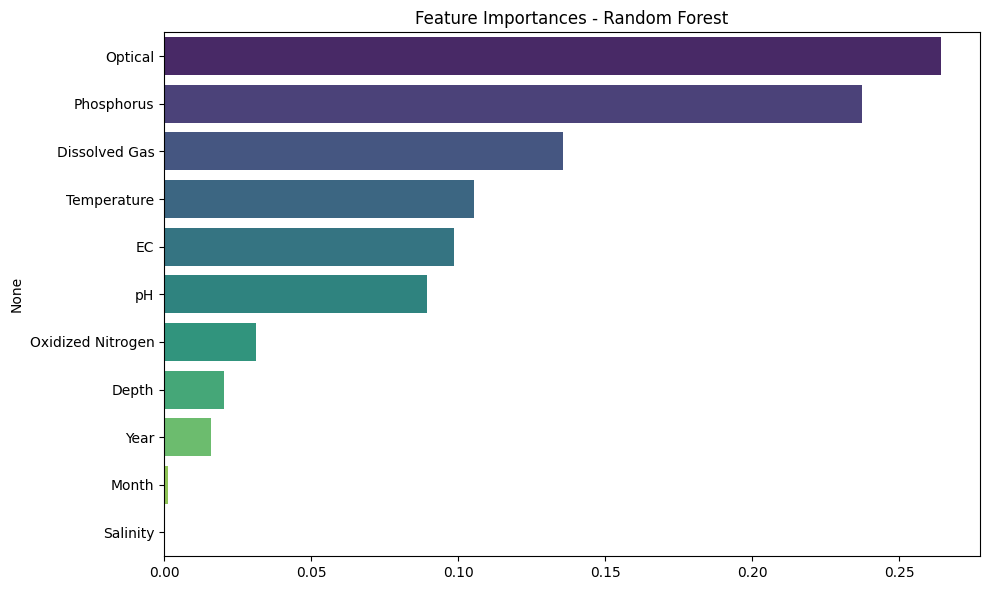

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.6f}")

cv_scores = cross_val_score(rf, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.6f}")

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances.values, 
    y=importances.index, 
    hue=importances.index, 
    palette="viridis", 
    legend=False
)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

notify_user("Training Complete", "The Random Forest model has finished training and evaluation.")

# **Logistic Regression**

Confusion Matrix:
[[56072 14965]
 [14473 72364]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     71037
           1       0.83      0.83      0.83     86837

    accuracy                           0.81    157874
   macro avg       0.81      0.81      0.81    157874
weighted avg       0.81      0.81      0.81    157874

Balanced Accuracy: 0.811333

CV Balanced Accuracy Scores: [0.73455788 0.67370874 0.8472445  0.76452029 0.68413518]
Mean CV Balanced Accuracy: 0.740833


C:\Users\Informatics\AppData\Local\Temp\ipykernel_19916\3575395980.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


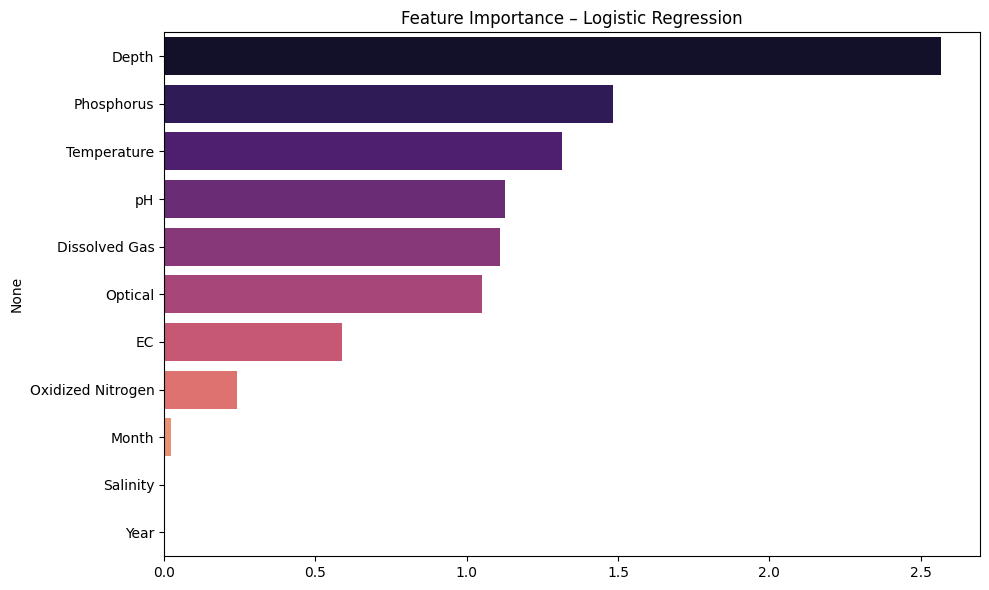

In [15]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=42
    ))
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
print(f"Balanced Accuracy: {bal_acc_lr:.6f}")

# Cross-validation
cv_scores_lr = cross_val_score(
    lr_pipeline, X, y, cv=5, scoring="balanced_accuracy"
)

print(f"\nCV Balanced Accuracy Scores: {cv_scores_lr}")
print(f"Mean CV Balanced Accuracy: {cv_scores_lr.mean():.6f}")

coef = lr_pipeline.named_steps["lr"].coef_[0]
importances_lr = pd.Series(np.abs(coef), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_lr.values,
    y=importances_lr.index,
    palette="magma",
    legend=False
)
plt.title("Feature Importance – Logistic Regression")
plt.tight_layout()
plt.show()

# **Decision Tree**

Confusion Matrix:
[[71037     0]
 [    0 86837]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71037
           1       1.00      1.00      1.00     86837

    accuracy                           1.00    157874
   macro avg       1.00      1.00      1.00    157874
weighted avg       1.00      1.00      1.00    157874

Balanced Accuracy: 1.000000

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.000000


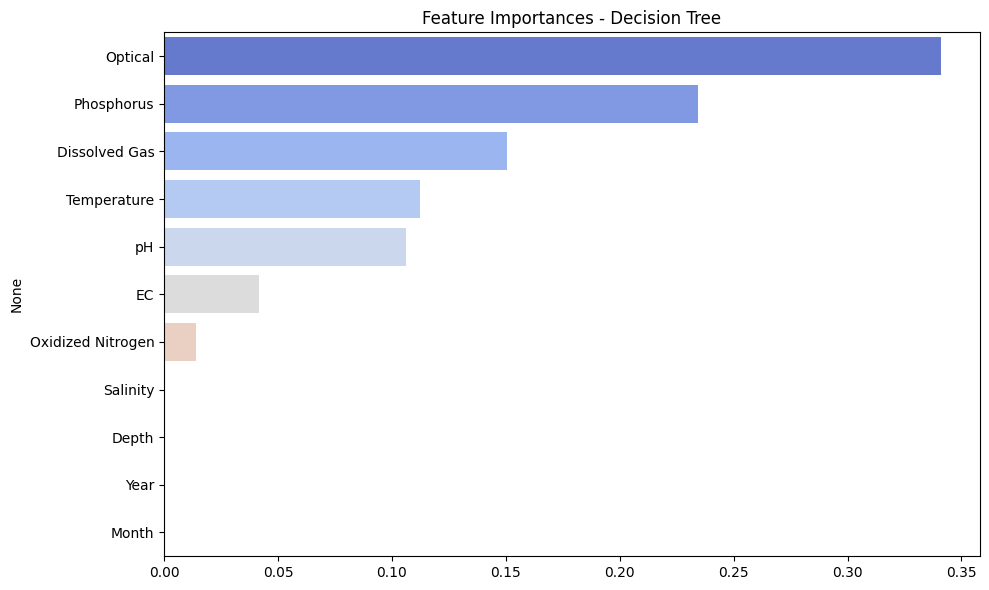

In [18]:
dt = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced'
)

# Train
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

bal_acc_dt = balanced_accuracy_score(y_test, y_pred_dt)
print(f"Balanced Accuracy: {bal_acc_dt:.6f}")

cv_scores_dt = cross_val_score(dt, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores_dt}")
print(f"Mean CV Accuracy: {cv_scores_dt.mean():.6f}")

importances_dt = pd.Series(dt.feature_importances_, index=X.columns)
importances_dt = importances_dt.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_dt.values, 
    y=importances_dt.index, 
    hue=importances_dt.index, 
    palette="coolwarm", 
    legend=False
)
plt.title("Feature Importances - Decision Tree")
plt.tight_layout()
plt.show()

# **XGBoost**

Confusion Matrix:
[[71033     4]
 [    0 86837]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71037
           1       1.00      1.00      1.00     86837

    accuracy                           1.00    157874
   macro avg       1.00      1.00      1.00    157874
weighted avg       1.00      1.00      1.00    157874

Balanced Accuracy: 0.999972

Cross-Validation Scores: [0.99997466 1.         1.         1.         0.999981  ]
Mean CV Accuracy: 0.999991


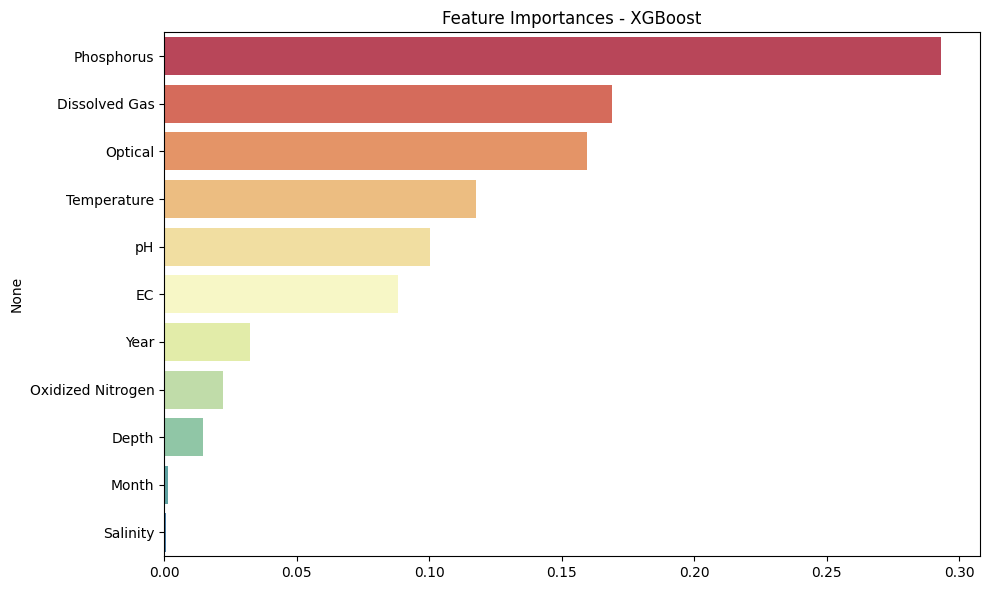

In [26]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb_clf.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy: {bal_acc_xgb:.6f}")

cv_scores_xgb = cross_val_score(xgb_clf, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores_xgb}")

print(f"Mean CV Accuracy: {cv_scores_xgb.mean():.6f}")

importances_xgb = pd.Series(xgb_clf.feature_importances_, index=X.columns)
importances_xgb = importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_xgb.values, 
    y=importances_xgb.index, 
    hue=importances_xgb.index, 
    palette="Spectral", 
    legend=False
)
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# **LightGBM**

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=-1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
# Train
lgb_clf.fit(X_train, y_train)
# Predict
y_pred_lgb = lgb_clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))
bal_acc_lgb = balanced_accuracy_score(y_test, y_pred_lgb)
print(f"Balanced Accuracy: {bal_acc_lgb:.6f}")
cv_scores_lgb = cross_val_score(lgb_clf, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_scores_lgb}")
print(f"Mean CV Accuracy: {cv_scores_lgb.mean():.6f}")
importances_lgb = pd.Series(lgb_clf.feature_importances_, index=X.columns)
importances_lgb = importances_lgb.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_lgb.values, 
    y=importances_lgb.index, 
    hue=importances_lgb.index, 
    palette="cubehelix", 
    legend=False
)
plt.title("Feature Importances - LightGBM")
plt.tight_layout()
plt.show()